In [1]:
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
import datetime 
from datetime import datetime 
import numpy as np

# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
#from neurone.runners.extended import HeatmapExtendedDetectionRunner
from neurone.runners.gridsearch import GridSearchRunner

E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}

#args.engine = "gpu"
#args.tracker = "tensorboard"

print('Get current working directory : ', os.getcwd())
config_path = "./configs/detection.json"
!cat ./configs/detection.json
with open(config_path, "r") as config_file:
        config = json.load(config_file)
        
        
config["data"]["split_info"] = "/home/data-histology/endonuke_data/trainval/split_info.yml"
config["train"]["experiment_name"] = config["train"]["save_dir"] + " " + config["train"]["experiment_name"]  + " " + str(datetime.now())
#whether to overwrite the model or not
#config["train"]["verbose"] = True
#config["train"]["overwrite"] = True
config["train"]["deterministic"] = False
config["train"]["seed"] = 42
config["train"]["checkpoints_dir"] = "checkpoints"
config["train"]["logging_dir"] = "logs"
config['train']['tracker'] = "tensorboard"
config["train"]["engine"] = "gpu"
if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E["gpu"](
    log_with="tensorboard", logging_dir=logging_dir), config=config)


Get current working directory :  /home/alexmak123/neurone
{
  "model": {
    "runner": "HeatmapDetectionRunner",
    "model_name": "HeatmapDetector",
    "model_kwargs": {
      "backbone": "Unet",
      "encoder_name": "resnet34",
      "encoder_depth": 5,
      "encoder_weights": "imagenet",
      "in_channels": 3,
      "classes": 2,
      "activation": null,
      "min_peak_value": 0.245,
      "pooling_scale": 7,
      "out_image_shape": [
        512,
        512
      ],
      "supression_range": 3.099
    },
    "weigths_path": "/home/alexmak123/neurone/experiments/experiment_2022-10-27 19:25:38.336325/model.pth",
    "class_separator": null,
    "class_labels_map": {
      "0": 0,
      "1": 1,
      "2": 0
    },
    "input_shape": [
      512,
      512
    ]
  },
  "data": {
    "split_info": null,
    "dataset_dir": "/home/data-histology/endonuke_data/trainval",
    "save_console_logs": true,
    "workers": 2,
    "heatmaps_sigma": 7.62,
    "norm_mean": [
      213,
     

In [2]:
# Specify Model
runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [3]:
#some transformations for propper data fromat
import albumentations as A
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])

#Download our tiles
%cd ../tmp_dir/tiles/21-177-1 CD138
#%ls 
#print('Get current working directory : ', os.getcwd())
directory_in_str = "/home/alexmak123/tmp_dir/tiles/21-177-1 CD138"

import cv2
from PIL import Image

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    converted_images = []
    i = 1
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("21-177-1 CD138"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            #print (myTile.shape)
            converted_images.append(myTile)
            i += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
%cd ../../

/home/alexmak123/tmp_dir/tiles/21-177-1 CD138
(5780, 512, 512, 3)
/home/alexmak123/tmp_dir


In [4]:
#here we choose on which devise to run our script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
print(torch.cuda.memory_summary(device=1, abbreviated=False))
runner.model.to(device)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 1                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

HeatmapDetector(
  (heatmap_model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [6]:
#here we choose on which tesla to run
!export CUDA_VISIBLE_DEVICES=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [7]:
##batch_size = 10
##iterations = image_torch.shape[0] // batch_size
##left = image_torch.shape[0] % batch_size

##all_keypoints = []
##all_confidences = []
##for i in range (iterations):
##    x = torch.empty(batch_size, image_torch.shape[1], image_torch.shape[2], image_torch.shape[3])
##    j = 0
##    while (j < batch_size):
##        x[j] = image_torch[batch_size * i + j]
##        j += 1
        
##    x = x.to(device)
##    keypoints = runner.model(x)["keypoints"]
##    all_keypoints.append(keypoints)
##    confidences = runner.model(x)["confidences"]
##    all_confidences.append(confidences

In [8]:
import sys


#our data to tensor
image_torch = torch.tensor(converted_images)
print (image_torch.shape)
#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()

#here should be meanstd values, counted for this picture, but with counted meanstd it doesn't classify properly on stroma and epithelium. That's why we use standard meanstd values

#!!!NOTE: ASK ABOUT THIS!!!
#config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2] = (170, 154, 144)
#config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2] = (63, 69, 71)
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)

torch.cuda.empty_cache()
#image_torch.to(device)

all_keypoints = []
all_confidences = []

for i in range (image_torch.shape[0]) :
    x = image_torch[i].to(device)
    x = torch.unsqueeze(x, 0)
    keypoints = runner.model(x)["keypoints"]
    all_keypoints.append(keypoints)
    confidences = runner.model(x)["confidences"]
    all_confidences.append(confidences)
                           
print ("Size Keypoints of all tiles : \n")
print (len(all_keypoints), "\n")
print ("Size Confidences of all tiles : \n")
print (len(all_confidences), "\n")

                           
#x_coords = keypoints.x_coords()
#y_coords = keypoints.y_coords()
#classes = keypoints.classes()

torch.Size([5780, 512, 512, 3])
Size Keypoints of all tiles : 

5780 

Size Confidences of all tiles : 

5780 



In [9]:
#right now we will count the color of our stromas (cutting out the center) (stromas are on the left picture above and they are colored in black)
#note : first we get rgb colors and then we should convert them to hsv (to get rid of the Blue part, so that we can define brown)
#in this function we have selected_colums, which are our keypoints; cell_size which is a size of our sell; and cut_center_size which is a size of a square that we are cutting from our original cell
import math

def pixel_values_of_the_toruses(selected_columns, myTile, cell_size, cut_center_size = 0):
    if (cut_center_size > cell_size):
        raise ValueError("your cut_center_size is more than a cell_size")
    
    list_of_cells = []
    for dot_center in selected_columns:
        #we want only stromas
        if (dot_center[2] == 0): 
            x = dot_center[0].astype(int)
            y = dot_center[1].astype(int)
        
            #here we count max bounds of i and j for cell size and cut_center_size
        
            #!!!
            max_bound_for_cell = cell_size//2 
            max_bound_for_cut_center = cut_center_size//2
            #!!!
        
            i, j = -max_bound_for_cell, -max_bound_for_cell
            myCell = []
            #print ("new pair " + str(cell_size) + "x" + str(cell_size) + " : \n")
            while (x+i >= 0 and x+i < 512 and i <= max_bound_for_cell):
                j = -max_bound_for_cell
                while (y+j >= 0 and y+j < 512 and j <= max_bound_for_cell):
                    if (i >= -max_bound_for_cut_center and i <= max_bound_for_cut_center and j >= -max_bound_for_cut_center and j <= max_bound_for_cut_center):
                        j += 1
                        continue
                    #print(i, j)
                    #print(myTile[x+i][y+j])
                    myCell.append(myTile[x+i][y+j])
                    j += 1
                i += 1
                
            #print(np.array(myCell))
            if(cut_center_size == 0):
                myCell.append(myTile[x][y])
            if (len(myCell) != 0):
                list_of_cells.append(myCell)
            
    return np.array(list_of_cells, dtype = object)


In [10]:
#now lets count the mean color in RGB for each tile and each torus of the stroma in this tile; convert mean rgb values to hsv and take only tors that have brown color
import colorsys

def count_brown_tors_for_each_tile (tors_pixel_values):
    hsv_values_of_brown_tors = []
    for elem in tors_pixel_values:
        rgb_mean = np.mean(elem, axis = 0)
        (rgb_mean[0], rgb_mean[1], rgb_mean[2]) = (rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
        hsv = colorsys.rgb_to_hsv(rgb_mean[0], rgb_mean[1], rgb_mean[2])
        hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
        #if hue is >= 10 and <= 20 then we have a brown spectre color
        if (hsv[0] >= 10 and hsv[0] <= 20 and hsv[2] <= 198):
            #print(hsv)
            hsv_values_of_brown_tors.append(hsv)
    return (np.array(hsv_values_of_brown_tors))


In [11]:
i = 0
dict = {}
for curr_keypoints in all_keypoints:
    selected_columns = np.array(curr_keypoints[:, [1,2,3]])
    brown_cells_on_this_tile = count_brown_tors_for_each_tile(pixel_values_of_the_toruses(selected_columns, converted_images[i], 19, 5))
    dict["Tile " + str(i)] = brown_cells_on_this_tile.size
    i += 1

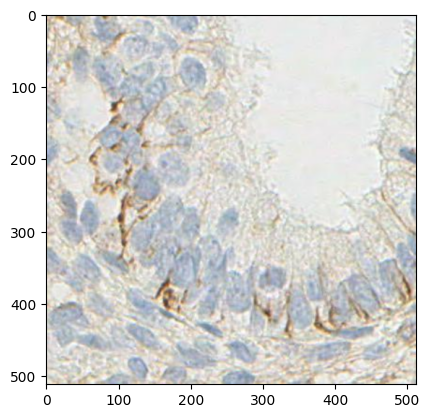

In [18]:
import matplotlib.pyplot as plt
import albumentations as A
%matplotlib inline

myTile = Image.fromarray(np.uint8(converted_images[3942])).convert('RGB')
plt.imshow(myTile)


In [19]:
sum_dict = 0
for key in dict:
    sum_dict += dict[key]

from contextlib import redirect_stdout

file = open('21-177-1 CD138.txt', 'w')
with file as f:
    with redirect_stdout(f):
        print (" Sum of brown cells : ", sum_dict, "\n")
        print (dict)
file.close() 
